[*********************100%%**********************]  1 of 1 completed
/home/guru/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2702/2702 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.0015
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
train_data_length: 2763
Length of scaled_data: 3454
Length of train_predict: 2702
Length of test_predict: 630


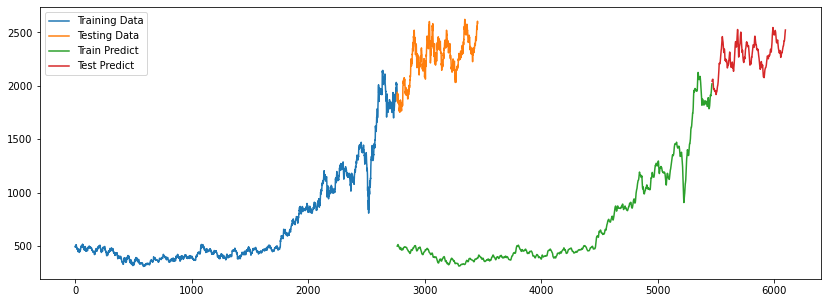

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

def download_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

ticker = 'RELIANCE.NS'
start_date = '2010-01-01'
end_date = '2024-01-01'
data = download_stock_data(ticker, start_date, end_date)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

train_data_length = len(train_data)
train_actual = scaler.inverse_transform(train_data)
test_actual = scaler.inverse_transform(test_data)

# Debugging print statements
print(f"train_data_length: {train_data_length}")
print(f"Length of scaled_data: {len(scaled_data)}")
print(f"Length of train_predict: {len(train_predict)}")
print(f"Length of test_predict: {len(test_predict)}")

plt.figure(figsize=(14, 5))
plt.plot(range(train_data_length), train_actual, label='Training Data')
plt.plot(range(train_data_length, len(scaled_data)), test_actual, label='Testing Data')
plt.plot(range(train_data_length, train_data_length + len(train_predict)), train_predict, label='Train Predict')
plt.plot(range(train_data_length + len(train_predict), train_data_length + len(train_predict) + len(test_predict)), test_predict, label='Test Predict')
plt.legend()
plt.show()
